In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [11]:
df = pd.read_csv('btc_eth_ltc.csv',index_col='Date')

In [12]:
df = df.sort_values('Date')
df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,ETHUSD,202.67,207.89,202.50,205.86,21165.529375
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
...,...,...,...,...,...,...,...
2021-09-21 04:00:00,1632196800000,ETHUSD,2998.29,3104.42,2650.85,2869.31,46289.916678
2021-09-21 04:00:00,1632196800000,LTCUSD,159.47,162.20,144.62,151.48,46606.739750
2021-09-22 04:00:00,1632283200000,BTCUSD,42089.88,44047.48,41836.59,43559.58,1051.581492


In [13]:
df['Symbol'].unique()

array(['ETHUSD', 'LTCUSD', 'BTCUSD'], dtype=object)

In [14]:
df.groupby('Symbol')['Unix Timestamp'].nunique()

Symbol
BTCUSD    1073
ETHUSD    1073
LTCUSD    1073
Name: Unix Timestamp, dtype: int64

<BarContainer object of 3 artists>

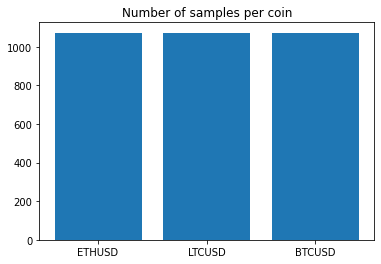

In [15]:
plt.title('Number of samples per coin')
plt.bar(df['Symbol'].unique(),df.groupby('Symbol')['Unix Timestamp'].nunique())

In [16]:
#Split dataframes
list_df = {}
for name in df['Symbol'].unique():
    print(name)
    list_df.update({name:df[df.Symbol==name]})

ETHUSD
LTCUSD
BTCUSD


In [17]:
ltc_df = list_df.get('LTCUSD')
btc_df = list_df.get('BTCUSD')
eth_df = list_df.get('ETHUSD')


In [18]:
ltc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
2018-10-18 04:00:00,1539835200000,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
2018-10-19 04:00:00,1539921600000,LTCUSD,51.88,51.88,51.88,51.88,0.000000
2018-10-20 04:00:00,1540008000000,LTCUSD,51.88,52.75,51.88,52.75,1.000000
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,LTCUSD,182.08,185.74,178.43,179.44,21093.113429
2021-09-19 04:00:00,1632024000000,LTCUSD,179.44,181.60,163.50,167.01,31279.361709
2021-09-20 04:00:00,1632110400000,LTCUSD,167.01,168.18,150.22,159.47,86803.808889


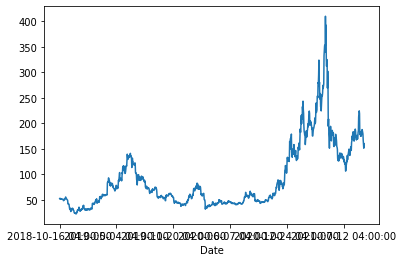

In [19]:
ltc_df['Close'].plot()

In [67]:
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [89]:
# fit model
def train_lstm(df, lookback = 365, forecast=7):
    series = pd.DataFrame(df['Close'])
    # plt.figure(figsize=(8,6))
    # plt.title("Original")
    # plt.grid()
    # plt.plot(series)
    mm_scaler = MinMaxScaler((0,1))
    mm_scaler.fit(series)
    series = mm_scaler.transform(series)
    # plt.figure(figsize=(8,6))
    # plt.title("Scaled")
    # plt.grid()
    # plt.plot(series)
    X = []
    y = []
    for i in range(lookback, len(series)-forecast):
        X.append(series[i-lookback:i,])
        y.append(series[i:i+forecast])
    X, y = np.array(X), np.array(y)
    X_train = X[:int(0.7*len(X))]
    X_test = X[int(0.7*len(X)):]

    y_train = y[:int(0.7*len(y))]
    y_test = y[int(0.7*len(y)):]
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    def model_lstm(lookback):
      model=Sequential()
      model.add(LSTM(32, input_shape=(lookback,1), return_sequences=True))
      model.add(LSTM(32, return_sequences=True))
      model.add(LSTM(7))
      model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
      print(model.summary())
      return model
    lstm = model_lstm(lookback)
    lstm.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=0,batch_size=32,epochs=50,callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    pred = lstm.predict(X_test)
    plt.figure(figsize=(8,6))
    plt.title("Predictions")
    plt.grid()
    plt.plot([y[0,0] for y in y_test])
    plt.plot([y[0] for y in pred])

    return lstm, mm_scaler


In [164]:
def forecast_lstm(lstm,df,scaler,lookback=365,forecast=7):
    import datetime
    series = pd.DataFrame(df['Close'])
    series.index = pd.to_datetime(series.index)
    max = series.index.max()
    series = pd.DataFrame(df['Close'])
    # plt.figure(figsize=(8,6))
    # plt.title("Original")
    # plt.grid()
    # plt.plot(series)
    mm_scaler = scaler
    series = mm_scaler.transform(series)
    X = np.expand_dims(series[-lookback:,],axis=0)

    predictions = pd.DataFrame(columns=['date','Close'])
    # walk-forward validation
    output = lstm.predict(X)
    yhat = output[0]
    dates = [max+datetime.timedelta(days=i) for i in range(forecast)]
    df = pd.DataFrame(np.vstack([dates,yhat]).T,columns=['date','Close'])
    df['Close'] = mm_scaler.inverse_transform(df['Close'].values.reshape(1,-1)).reshape(forecast)
    predictions=pd.concat([predictions,df])

    predictions.index = predictions['date']
    predictions.drop('date',axis=1,inplace=True)
    return predictions

## LTC

(490, 365, 1) (490, 7, 1) (211, 365, 1) (211, 7, 1)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 365, 32)           4352      
_________________________________________________________________
lstm_44 (LSTM)               (None, 365, 32)           8320      
_________________________________________________________________
lstm_45 (LSTM)               (None, 7)                 1120      
Total params: 13,792
Trainable params: 13,792
Non-trainable params: 0
_________________________________________________________________
None


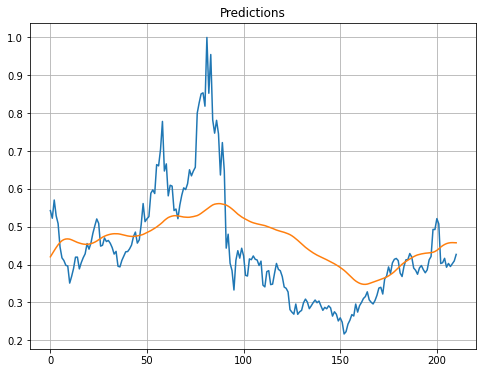

In [90]:
lstm,scaler = train_lstm(ltc_df)

In [160]:
pred =forecast_lstm(lstm,ltc_df,scaler) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,197.866802
2021-09-23 04:00:00,181.589418
2021-09-24 04:00:00,184.557677
2021-09-25 04:00:00,187.523790
2021-09-26 04:00:00,201.813644
2021-09-27 04:00:00,188.327040
2021-09-28 04:00:00,194.328390


In [162]:
ltc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
2018-10-18 04:00:00,1539835200000,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
2018-10-19 04:00:00,1539921600000,LTCUSD,51.88,51.88,51.88,51.88,0.000000
2018-10-20 04:00:00,1540008000000,LTCUSD,51.88,52.75,51.88,52.75,1.000000
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,LTCUSD,182.08,185.74,178.43,179.44,21093.113429
2021-09-19 04:00:00,1632024000000,LTCUSD,179.44,181.60,163.50,167.01,31279.361709
2021-09-20 04:00:00,1632110400000,LTCUSD,167.01,168.18,150.22,159.47,86803.808889


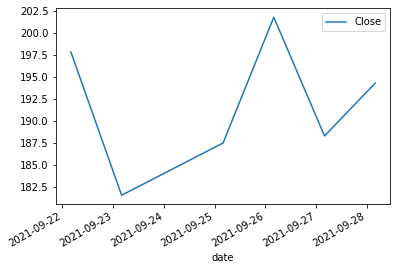

In [163]:
pred.plot()

## BTC

In [ ]:
btc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-18 04:00:00,1539835200000,BTCUSD,6459.26,6459.64,6350.92,6383.39,4597.200330
2018-10-19 04:00:00,1539921600000,BTCUSD,6383.39,6383.39,6383.39,6383.39,0.000000
2018-10-20 04:00:00,1540008000000,BTCUSD,6383.39,6386.34,6382.00,6382.04,2.701644
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,BTCUSD,47962.79,48808.97,47613.93,47854.23,671.356150
2021-09-19 04:00:00,1632024000000,BTCUSD,47854.23,48333.32,45175.20,45553.62,860.712331
2021-09-20 04:00:00,1632110400000,BTCUSD,45553.62,45837.90,40137.98,42688.03,4373.379477


(490, 365, 1) (490, 7, 1) (211, 365, 1) (211, 7, 1)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 365, 32)           4352      
_________________________________________________________________
lstm_47 (LSTM)               (None, 365, 32)           8320      
_________________________________________________________________
lstm_48 (LSTM)               (None, 7)                 1120      
Total params: 13,792
Trainable params: 13,792
Non-trainable params: 0
_________________________________________________________________
None


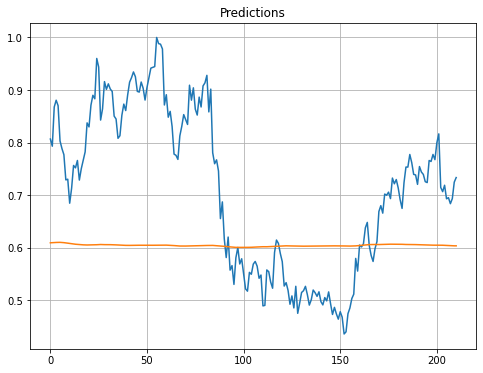

In [165]:
lstm,scaler = train_lstm(btc_df)

In [166]:
pred =forecast_lstm(lstm,btc_df,scaler) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,39735.983647
2021-09-23 04:00:00,44281.703680
2021-09-24 04:00:00,42962.233211
2021-09-25 04:00:00,42832.084825
2021-09-26 04:00:00,42282.002196
2021-09-27 04:00:00,46258.577117
2021-09-28 04:00:00,47216.271970


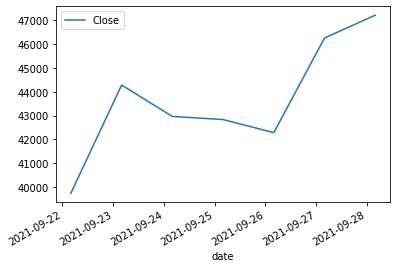

In [167]:
pred.plot()

## ETH

(490, 365, 1) (490, 7, 1) (211, 365, 1) (211, 7, 1)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 365, 32)           4352      
_________________________________________________________________
lstm_50 (LSTM)               (None, 365, 32)           8320      
_________________________________________________________________
lstm_51 (LSTM)               (None, 7)                 1120      
Total params: 13,792
Trainable params: 13,792
Non-trainable params: 0
_________________________________________________________________
None


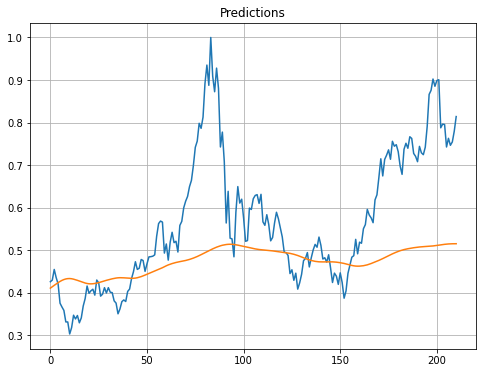

In [168]:
lstm,scaler = train_lstm(eth_df)

In [169]:
pred =forecast_lstm(lstm,eth_df,scaler) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,2271.831486
2021-09-23 04:00:00,2120.485124
2021-09-24 04:00:00,2613.633288
2021-09-25 04:00:00,2416.178804
2021-09-26 04:00:00,2862.039475
2021-09-27 04:00:00,2107.070892
2021-09-28 04:00:00,2309.690477


In [170]:
eth_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,ETHUSD,202.67,207.89,202.50,205.86,21165.529375
2018-10-17 04:00:00,1539748800000,ETHUSD,205.86,206.05,201.35,204.60,11431.196005
2018-10-18 04:00:00,1539835200000,ETHUSD,204.60,204.78,196.97,199.43,24540.877376
2018-10-19 04:00:00,1539921600000,ETHUSD,199.43,199.43,199.43,199.43,0.000000
2018-10-20 04:00:00,1540008000000,ETHUSD,199.43,200.73,199.43,200.73,4.687530
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,ETHUSD,3452.36,3541.89,3374.61,3413.18,7627.867957
2021-09-19 04:00:00,1632024000000,ETHUSD,3413.18,3458.96,3157.41,3187.56,15668.045794
2021-09-20 04:00:00,1632110400000,ETHUSD,3187.56,3218.18,2807.97,2998.29,49242.010484


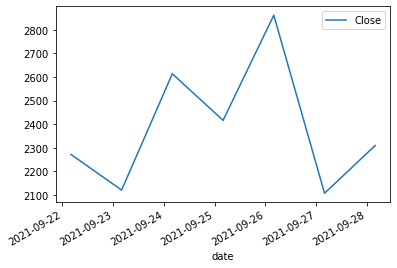

In [171]:
pred.plot()